**Scope**: Evaluating MegaDetector's Baseline Performance on Camouflaged Wildlife Imagery

**Preprocessing**:
To align with the revised scope, we filtered the dataset to exclude all non-camouflaged (Non-CA), aquatic, and human-related images. Our focus is solely on camouflaged wildlife, as per the updated objective of evaluating MegaDetector’s (MD) performance in this domain.

**Approach**:
We utilized the object detection model provided in the following repository:

https://github.com/microsoft/CameraTraps/tree/main/PytorchWildlife

Specifically, we employed MegaDetector v6 to perform inference on the COD10K dataset.

The detection results were saved in JSON format, with each file corresponding to an individual image.

These JSON files were stored in a separate directory to facilitate organized analysis.

We then parsed the detection outputs to identify images labeled as containing animals. If an image was labelled as having 2 of the same categories, we only incremented that category count as 1. If an image was classified as having 2 different categories, we incremented the category count of the category with the higher confidence count. Since the COD10K subset under analysis includes only animal images, any detection label other than "animal" is treated as a false positive.

**Key Considerations**:
This work follows from the discussion and clarification in our last evaluation session with Dr. Murtuza Taj, where the scope of this deliverable was refined. Our task is not to build or test a full classifier or a detector-to-classifier pipeline, but rather to evaluate MegaDetector directly on COD10K imagery.

It is important to note that an image being labeled as "animal" by MD does not guarantee correct detection:

We must evaluate whether the model correctly identifies how many animals are present in each image.

Furthermore, we will inspect the bounding box coordinates returned by the model to verify whether it is localizing the correct regions where animals are actually present. Mislocalized detections, even if labeled correctly, are considered inaccurate under this scope.


In [ ]:
!pip install PytorchWildlife

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 820.5/820.5 kB 15.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
from PytorchWildlife.models import detection as pw_detection
# from PytorchWildlife.models import classification as pw_classification



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results


wandb: Enter your choice: (30 second timeout) 3


wandb: You chose "Don't visualize my results"
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
detection_model = pw_detection.MegaDetectorV6(version="MDV6-yolov10-e") # Model weights are automatically downloaded.
# classification_model = pw_classification.AI4GSnapshotSerengeti()

Ultralytics 8.3.108 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10x summary (fused): 215 layers, 31,589,858 parameters, 0 gradients, 169.8 GFLOPs


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
image_folder = '/content/drive/MyDrive/DL data/unzipped_images/unzipped/Image'
output_folder = '/content/drive/MyDrive/DL data/detection_files_real'
os.makedirs(output_folder, exist_ok=True)
import json
for filename in os.listdir(image_folder):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(image_folder, filename)

        # Run detection
        detection_result = detection_model.single_image_detection(img_path)

        # Convert detection_result to JSON-serializable dict
        detections = detection_result['detections']
        json_safe_result = {
            'img_id': detection_result['img_id'],
            'detections': {
                'xyxy': detections.xyxy.tolist() if detections.xyxy is not None else [],
                'confidence': detections.confidence.tolist() if detections.confidence is not None else [],
                'class_id': detections.class_id.tolist() if detections.class_id is not None else [],
            },
            'labels': detection_result.get('labels', [])
        }

        # Save result
        json_path = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}.json")
        with open(json_path, 'w') as f:
            json.dump(json_safe_result, f)

        print(f"Detection result for {filename} saved to: {json_path}")


Streaming output truncated to the last 5000 lines.

0: 640x640 1 vehicle, 46.0ms
Speed: 3.6ms preprocess, 46.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Detection result for COD10K-CAM-3-Flying-62-Mantis-4301.jpg saved to: /content/drive/MyDrive/DL data/detection_files_real/COD10K-CAM-3-Flying-62-Mantis-4301.json

0: 640x640 2 animals, 45.4ms
Speed: 5.4ms preprocess, 45.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Detection result for COD10K-CAM-3-Flying-62-Mantis-4274.jpg saved to: /content/drive/MyDrive/DL data/detection_files_real/COD10K-CAM-3-Flying-62-Mantis-4274.json

0: 640x640 (no detections), 46.7ms
Speed: 3.7ms preprocess, 46.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)
Detection result for COD10K-CAM-3-Flying-62-Mantis-4279.jpg saved to: /content/drive/MyDrive/DL data/detection_files_real/COD10K-CAM-3-Flying-62-Mantis-4279.json

0: 640x640 (no detections), 47.3ms
Speed: 3.8ms preprocess, 47.3ms inferenc

In [22]:
json_folder = '/content/drive/MyDrive/DL data/detection_files_real'
import os

# Initialize counters
animal_count = 0
person_count = 0
vehicle_count = 0
none_count = 0

# Loop through each detection result
for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        json_path = os.path.join(json_folder, filename)

        with open(json_path, 'r') as f:
            data = json.load(f)

        labels = data.get('labels', [])

        if not labels:
            none_count += 1
            continue

        # Extract category and confidence from each label
        best_category = None
        best_confidence = -1

        for label in labels:
            try:
                category, confidence = label.split()
                confidence = float(confidence)

                if confidence > best_confidence:
                    best_confidence = confidence
                    best_category = category
            except:
                continue  # just in case a label is malformed

        # Increment the counter for the category with highest confidence
        if best_category == 'animal':
            animal_count += 1
        elif best_category == 'person':
            person_count += 1
        elif best_category == 'vehicle':
            vehicle_count += 1
        else:
            none_count += 1  # fallback

# Output final summary
print("Most Confident Category per Image:")
print(f"animal:  {animal_count}")
print(f"person:  {person_count}")
print(f"vehicle: {vehicle_count}")
print(f"none:    {none_count}")


Most Confident Category per Image:
animal:  630
person:  131
vehicle: 158
none:    633


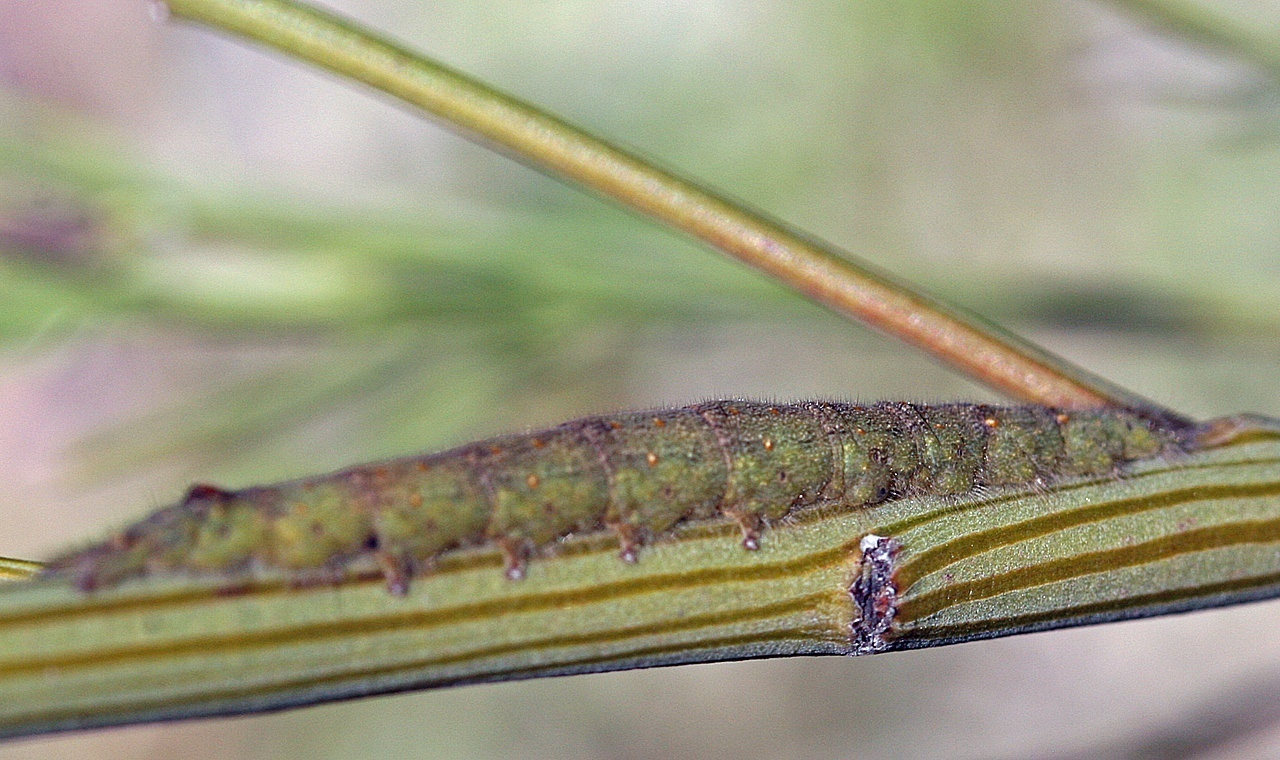

Image: /content/drive/MyDrive/DL data/unzipped_images/unzipped/Image/COD10K-CAM-2-Terrestrial-24-Caterpillar-1552.jpg
Detections: 2
--------------------------------------------------


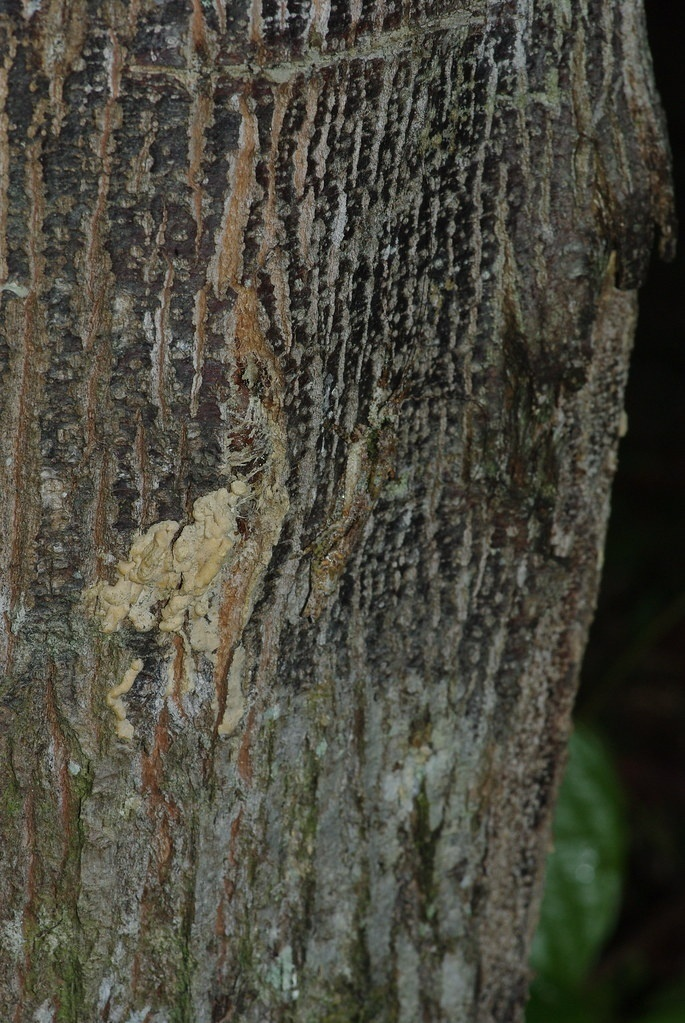

Image: /content/drive/MyDrive/DL data/unzipped_images/unzipped/Image/COD10K-CAM-3-Flying-61-Katydid-4122.jpg
Detections: 1
--------------------------------------------------


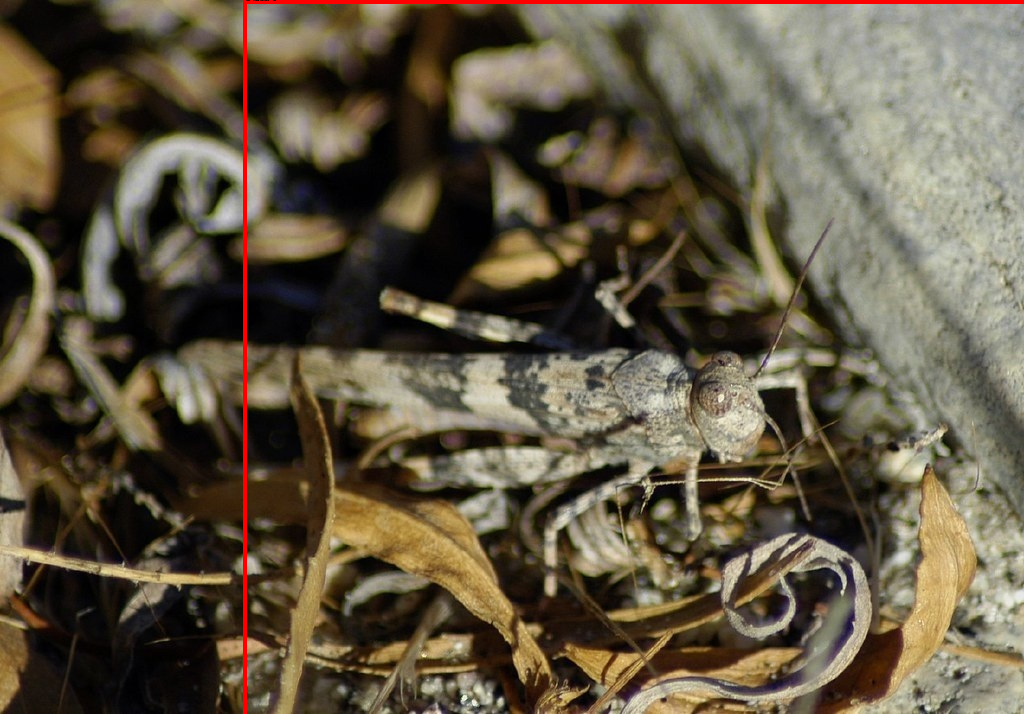

Image: /content/drive/MyDrive/DL data/unzipped_images/unzipped/Image/COD10K-CAM-3-Flying-59-Grasshopper-3650.jpg
Detections: 2
--------------------------------------------------


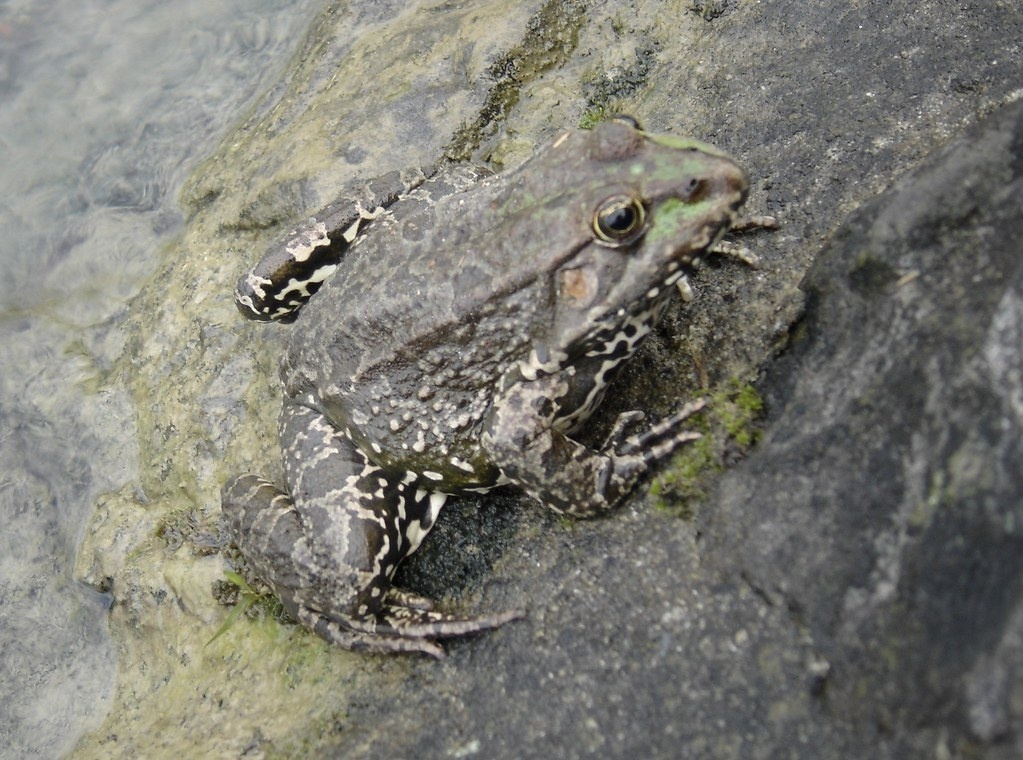

Image: /content/drive/MyDrive/DL data/unzipped_images/unzipped/Image/COD10K-CAM-4-Amphibian-68-Toad-5008.jpg
Detections: 1
--------------------------------------------------


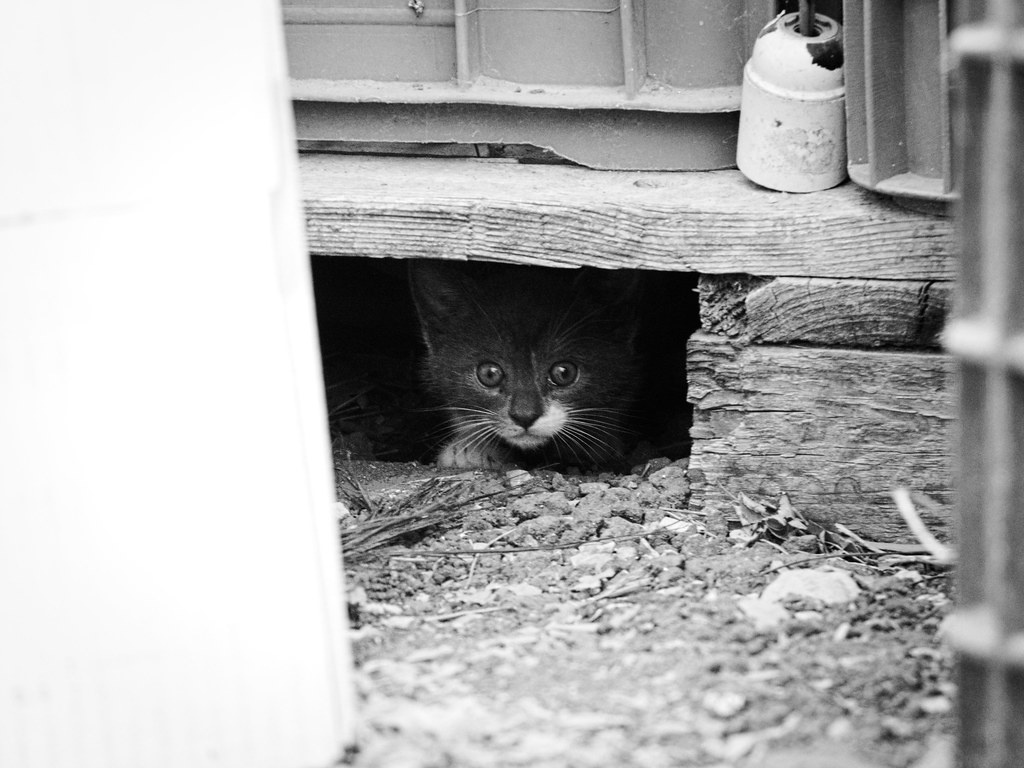

Image: /content/drive/MyDrive/DL data/unzipped_images/unzipped/Image/COD10K-CAM-2-Terrestrial-23-Cat-1471.jpg
Detections: 1
--------------------------------------------------

Found 919 images with detections (out of 1552 total)


In [26]:
import os
import json
import random
import numpy as np
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

# Constants
DEFAULT_BOX_THICKNESS = 4
DEFAULT_COLORS = [
    (255, 0, 0),    # Red
    (0, 255, 0),    # Green
    (0, 0, 255),    # Blue
    (255, 255, 0),  # Yellow
    (255, 0, 255)   # Magenta
]
TEXTALIGN_LEFT = 'left'

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, class_id,
                             thickness=4, expansion=0, display_str_list=None,
                             colormap=DEFAULT_COLORS, textalign=TEXTALIGN_LEFT):
    """Draws a single bounding box on image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size

    # Scale coordinates from normalized to absolute
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height)

    # Apply expansion
    left -= expansion
    right += expansion
    top -= expansion
    bottom += expansion

    # Get color based on class
    color = colormap[class_id % len(colormap)]

    # Draw rectangle
    draw.rectangle([(left, top), (right, bottom)],
                   outline=color,
                   width=thickness)

    # Draw text
    if display_str_list:
        font = ImageFont.load_default()
        text_bottom = top
        for display_str in display_str_list:
            # Modern way to get text size
            text_bbox = font.getbbox(display_str)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]

            margin = np.ceil(0.05 * text_height)
            draw.rectangle(
                [(left, text_bottom - text_height - 2 * margin),
                 (left + text_width, text_bottom)],
                fill=color)
            draw.text(
                (left + margin, text_bottom - text_height - margin),
                display_str,
                fill='black',
                font=font)
            text_bottom -= text_height + 2 * margin

def draw_bounding_boxes_on_image(image, boxes, classes, confidences,
                                thickness=DEFAULT_BOX_THICKNESS, expansion=0,
                                colormap=DEFAULT_COLORS):
    """Modified to work with your JSON format."""
    if not boxes or len(boxes) == 0:
        return None  # Return None instead of image when no detections

    # Convert xyxy format to ymin, xmin, ymax, xmax
    boxes = np.array(boxes)
    if boxes.shape[1] == 4:  # Already in xyxy format
        boxes = boxes[:, [1, 0, 3, 2]]  # Convert to ymin, xmin, ymax, xmax

    display_strs = []
    for class_id, confidence in zip(classes, confidences):
        display_strs.append([f"Class: {class_id}", f"Conf: {confidence:.2f}"])

    for i in range(len(boxes)):
        draw_bounding_box_on_image(
            image,
            boxes[i, 0], boxes[i, 1], boxes[i, 2], boxes[i, 3],
            classes[i],
            thickness=thickness,
            expansion=expansion,
            display_str_list=display_strs[i],
            colormap=colormap
        )
    return image

def visualize_detected_images(json_folder, num_images=5):
    """Visualize ONLY images with detections."""
    # Get all JSON files
    json_files = [f for f in os.listdir(json_folder) if f.endswith('.json')]
    detected_images = []

    # First pass: Collect images with detections
    for json_file in json_files:
        with open(os.path.join(json_folder, json_file), 'r') as f:
            data = json.load(f)

        if len(data['detections']['xyxy']) > 0:  # Only consider images with detections
            detected_images.append(json_file)

    # Select random subset
    selected_files = random.sample(detected_images, min(num_images, len(detected_images)))

    for json_file in selected_files:
        with open(os.path.join(json_folder, json_file), 'r') as f:
            data = json.load(f)

        # Load image
        img_path = data['img_id'].replace('\\', '/')
        try:
            image = Image.open(img_path)
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
            continue

        # Get detection data
        boxes = data['detections']['xyxy']
        classes = data['detections']['class_id']
        confidences = data['detections']['confidence']

        # Draw bounding boxes (guaranteed to have detections)
        annotated_image = draw_bounding_boxes_on_image(
            image.copy(), boxes, classes, confidences
        )

        # Display
        display(annotated_image)
        print(f"Image: {img_path}")
        print(f"Detections: {len(boxes)}")
        print("-" * 50)

    # Report stats
    print(f"\nFound {len(detected_images)} images with detections (out of {len(json_files)} total)")
    if len(detected_images) < num_images:
        print(f"Note: Only {len(detected_images)} images had detections")

# Usage
json_folder = '/content/drive/MyDrive/DL data/detection_files_real'
visualize_detected_images(json_folder, 5)

In [25]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
# drive.mount('/content/drive')

# Path to your JSON files folder
json_folder = '/content/drive/MyDrive/DL data/detection_files_real'  # Update this path

# Initialize list to store all confidence values
all_confidences = []

# Process each JSON file
for filename in os.listdir(json_folder):
    if filename.endswith('.json'):
        filepath = os.path.join(json_folder, filename)

        with open(filepath, 'r') as f:
            data = json.load(f)

            # Extract confidence values
            confidences = data['detections']['confidence']
            all_confidences.extend(confidences)

# Convert to numpy array for analysis
confidences_array = np.array(all_confidences)

# Basic statistics
stats = {
    'Mean': np.mean(confidences_array),
    'Median': np.median(confidences_array),
    'Minimum': np.min(confidences_array),
    'Maximum': np.max(confidences_array),
    'Std Dev': np.std(confidences_array),
    '25th Percentile': np.percentile(confidences_array, 25),
    '75th Percentile': np.percentile(confidences_array, 75)
}

# Print statistics
print("Confidence Score Analysis:")
for key, value in stats.items():
    print(f"{key}: {value:.4f}")

# Visualization
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(confidences_array, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(confidences_array, vert=False)
plt.title('Boxplot of Confidence Scores')
plt.xlabel('Confidence Score')

plt.tight_layout()
plt.show()

# Interpretation
mean_confidence = stats['Mean']
if mean_confidence > 0.7:
    print("\nThe MegaDetector is generally detecting with HIGH confidence.")
elif mean_confidence > 0.4:
    print("\nThe MegaDetector is detecting with MODERATE confidence.")
else:
    print("\nThe MegaDetector is detecting with LOW confidence.")

# Count of high-confidence detections (threshold = 0.8)
high_conf = np.sum(confidences_array >= 0.8)
print(f"\nNumber of high-confidence detections (≥0.8): {high_conf}/{len(confidences_array)} ({high_conf/len(confidences_array):.1%})")

Confidence Score Analysis:
Mean: 0.5133
Median: 0.4663
Minimum: 0.2004
Maximum: 0.9855
Std Dev: 0.2385
25th Percentile: 0.2926
75th Percentile: 0.7289

The MegaDetector is detecting with MODERATE confidence.

Number of high-confidence detections (≥0.8): 223/1190 (18.7%)


In [19]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Evaluations/Findings**:
MegaDetector was correct in detecting animals 41% of the time (keeping in mind the prevous mentioned considerations)
Most Confident Category per Image:
animal:  630
person:  131
vehicle: 158
none:    633

As ooposed to intuition, MD detects categories in camouflaged images with moderate confidence. Intuition suggests that with camouflaged imagery the MD would not detect a category with as high of a confidence as it would with salient/non-camouflged imagery with some confidence values as high as 0.98.

Confidence Score Analysis:
Mean: 0.5133
Median: 0.4663
Minimum: 0.2004
Maximum: 0.9855
Std Dev: 0.2385
25th Percentile: 0.2926
75th Percentile: 0.7289

The MegaDetector is detecting with MODERATE confidence.

Number of high-confidence detections (≥0.8): 223/1190 (18.7%)

We also observed that 60% images were falsely or correctly detected by the MD to have atleast 1 of the 3 categories : Person, animal, and vehicle, even though all images had instances of animals.This shows that 40% images were not classified into any categories so it means that the MD is failing and is not confident enough.
Found 919 images with detections (out of 1552 total)